# Phase transitions for real and artificial graphs

Import libraries and data

In [5]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from itertools import tee,combinations
import networkx as nx
import glob
import sqlite3
import statistics
from PIL import Image

In [100]:
# Import data
matrices = [np.genfromtxt(file) for file in glob.glob('1000_Functional_Connectomes\Connectivity matrices\*.txt')]

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\cyril\AppData\Local\Temp\ipykernel_22872\3713247554.py:2: SyntaxWarning: invalid escape sequence '\C'
  matrices = [np.genfromtxt(file) for file in glob.glob('1000_Functional_Connectomes\Connectivity matrices\*.txt')]


Define functions to generate: 
- a scale free graph for a given density
- an erdos renyi graph for a given density
- a real data graph for a given density
- a clique complex for a given graph
- a list a free energies over a range of temperatures for a given clique complex

In [154]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

# Obtain scipy minimized free energy and calculate the analytical minimum U and maximum S
def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    p_list = []
    temperature_list = np.arange(0.01, 1.0, 0.01)

    for temperature in temperature_list:
        f, p = complete_f_generator_scipy(clique_complex, temperature)
        f_list.append(f)
        p_list.append(p)

    return f_list, temperature_list, min_energy_value, min_energy_probabilities, max_entropy_value, p_Smax, p_list

# Generate a scale free graph (with nodal degrees distributed as powerlaw)
def generate_scale_free_graph(n, density):
    # Create a scale-free graph
    G = nx.scale_free_graph(n)

    # Undirected
    G = G.to_undirected()

    # Compute the total number of edges to keep
    total_edges = int((n * (n - 1)) / 2) * density

    # Calculate the number of edges to remove
    edges_to_remove = int(G.number_of_edges() - total_edges)

    # Remove edges to achieve the desired density
    if edges_to_remove > 0:
        G.remove_edges_from(list(G.edges())[:edges_to_remove])
    
    return G

# Generate a graph from real data for a given correlation matrix and density
def generate_real_data_graph(matrix, density, DIAGNOSTIC=False):
    # Fernando's function from network_TDA_tutorial
    np.fill_diagonal(matrix, 0)
    temp = sorted(matrix.ravel(), reverse=True)
    size = len(matrix)
    cutoff = np.ceil(density*(size*(size-1)))
    tre = temp[int(cutoff)]
    G0 = nx.from_numpy_matrix(matrix)
    G0.remove_edges_from(list(nx.selfloop_edges(G0)))
    G1 = nx.from_numpy_matrix(matrix)
    for u,v,a in G0.edges(data=True):
        if (a.get('weight')) <= tre:
            G1.remove_edge(u, v)
    finaldensity = nx.density(G1)
    if DIAGNOSTIC == True:
        print(finaldensity)
    return G1

# Generate a graph from real data for a given correlation matrix and threshold
def generate_real_clique_complex_threshold(correlation_matrix, threshold, max_clique_size):
    n = correlation_matrix.shape[0]
    G = nx.Graph()
    for i in range(n):
        for j in range(i + 1, n):
            if abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j)

    Cl = (i for i in nx.find_cliques(G))

    C = (tuple(sorted(c)) for c in Cl)
    C = tee(C, max_clique_size+1)

    cliques = [[] for _ in range(max_clique_size+1)]

    for i in range(max_clique_size+1):
        K = (i for i in set(c for mc in C[i] for c in combinations(mc, i+1)))
        for c in K:
            cliques[i].append(frozenset(c))

    result = []
    for i in range(max_clique_size+1):
        result.extend(sorted(cliques[i], key=lambda x: (len(x), sorted(x))))

    return result

# Build clique complex using gudhi to improve speed over networkx
def build_clique_complex_graph(G, max_clique_size):
    Cl = (i for i in nx.find_cliques(G))

    C = (tuple(sorted(c)) for c in Cl)
    C = tee(C, max_clique_size+1)

    cliques = [[] for _ in range(max_clique_size+1)]

    for i in range(max_clique_size+1):
        K = (i for i in set(c for mc in C[i] for c in combinations(mc, i+1)))
        for c in K:
            cliques[i].append(frozenset(c))

    result = []
    for i in range(max_clique_size+1):
        result.extend(sorted(cliques[i], key=lambda x: (len(x), sorted(x))))

    return result

# Generate average list of a list of lists
def average_list(list_of_lists):
    # Get the length of the first list to determine the size of the result list
    list_length = len(list_of_lists[0])
    
    # Initialize the result list with zeros
    avg_list = [0] * list_length
    
    # Iterate over each list element-wise and calculate the mean
    for sub_list in list_of_lists:
        avg_list = [sum(x) for x in zip(avg_list, sub_list)]
    
    # Divide each element in the result list by the number of lists
    avg_list = [x / len(list_of_lists) for x in avg_list]
    
    return avg_list

Generate real and artificial datasets

In [155]:
# Define desired settings and generate graph datasets
dataset_size = 100
density = 0.1
threshold = 0.75
nodes = 116
max_clique_size = 3
CC_scale_free = []
CC_erdos_renyi = []
CC_real_data = []
CC_real_data_threshold = []

for _ in range(dataset_size):
    # CC from scale free
    G = generate_scale_free_graph(nodes, density)
    clique_complex = build_clique_complex_graph(G, max_clique_size)
    CC_scale_free.append(clique_complex)

    # CC from erdos renyi
    G = nx.erdos_renyi_graph(nodes, density)
    clique_complex = build_clique_complex_graph(G, max_clique_size)
    CC_erdos_renyi.append(clique_complex)

    # CC from real data
    G = generate_real_data_graph(matrices[_], density, DIAGNOSTIC=False)
    clique_complex = build_clique_complex_graph(G, max_clique_size)
    CC_real_data.append(clique_complex)

    # CC from real data threshold
    clique_complex = generate_real_clique_complex_threshold(matrices[_], threshold, max_clique_size)
    CC_real_data_threshold.append(clique_complex)

Choose dataset to obtain FvsT data

In [156]:
dataset = CC_scale_free
name = 'scale_free_detailed'

Generate and store FvsT data

In [157]:
# Connect to the SQLite database (creates the database if it doesn't exist)
conn = sqlite3.connect(f'FvsT_{name}.db')

# Create a cursor object to execute SQL queries
c = conn.cursor()

# Create a table to store the data
c.execute('''CREATE TABLE IF NOT EXISTS data
             (id INTEGER PRIMARY KEY, list1 TEXT, list2 TEXT, list3 TEXT, list4 TEXT)''')

# Generate and store data in the database
for i in range(len(dataset)):

    clique_complex = dataset[i]
    if len(clique_complex) <= 600:
        
        # Generate your lists here
        f_list, temperature_list, min_energy_value, min_energy_probabilities, max_entropy_value, max_entropy_probabilities, p_list = complete_f_generator(clique_complex)
        
        list1 = f_list
        list2 = [arr.tolist() for arr in p_list]
        list3 = min_energy_probabilities.tolist()  # Convert array to list for list3
        list4 = max_entropy_probabilities.tolist()  # Convert array to list for list4

        # Insert the data into the database
        c.execute('''INSERT INTO data (list1, list2, list3, list4)
                    VALUES (?, ?, ?, ?)''', (str(list1), str(list2), str(list3), str(list4)))

# Commit changes and close the connection
conn.commit()
conn.close()

c:\Users\cyril\anaconda3\envs\TDA_brain\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


# Plot the FvsT data for the chosen dataset

In [158]:
name = 'scale_free_detailed'
dataset_size = len(dataset)

Extract desired lists from saved data

In [159]:
# Connect to the SQLite database
conn = sqlite3.connect(f'FvsT_{name}.db')

# Create a cursor object to execute SQL queries
c = conn.cursor()

# Execute a query to fetch the data from the table
c.execute('''SELECT * FROM data''')

# Fetch all rows from the result set
rows = c.fetchall()

# Process the retrieved data to obtain the original lists and arrays
original_data = []
for row in rows:
    list1 = eval(row[1])  # Convert the string representation of the list back to a list
    
    # Convert the string representation of list2 (list of arrays) back to a list of arrays
    list2 = eval(row[2])
    list3 = eval(row[3])
    list4 = eval(row[4]) 
    
    # Convert the string representation of array3 and array4 back to NumPy arrays
    #array3 = np.fromstring(row[3], dtype=float, sep=' ')
    #array4 = np.fromstring(row[4], dtype=float, sep=' ')
    
    original_data.append((list1, list2, list3, list4))

# Close the connection
conn.close()

# Connect to desired lists
f_list_iterations = list(zip(*original_data))[0]
p_list_iterations = list(zip(*original_data))[1]
P_Umin_list = list(zip(*original_data))[2]
P_Smax_list = list(zip(*original_data))[3]

Compute normalised free energy (between 0 and 1)

In [160]:
f_normalised_iterations = []
#f_list_iterations.pop(11) # remove any desired faulty datapoints, f.e. index 11

for f_list in f_list_iterations:
    min_val = min(f_list)
    max_val = max(f_list)
    f_normalised = [(val-min_val)/(max_val-min_val) for val in f_list]
    f_normalised_iterations.append(f_normalised)

Compute normalised probabilities (between 0 and 1)

In [161]:
p_normalised_iterations = []

for p_list in p_list_iterations:
    p_normalised_list = []

    for p_distribution in p_list:
        min_val = min(p_distribution)
        max_val = max(p_distribution)
        if min_val != max_val:
            p_normalised = [(val-min_val)/(max_val-min_val) for val in p_distribution]
        else:
            p_normalised = [0.5]*len(p_distribution)
        p_normalised_list.append(p_normalised)

    p_normalised_iterations.append(p_normalised_list)

Compute transitions between n-simplices

In [162]:
clique_complex = dataset[40]

N_nodes = sum(1 for s in clique_complex if len(s) == 1)
N_edges = sum(1 for s in clique_complex if len(s) == 2)
N_triangles = sum(1 for s in clique_complex if len(s) == 3)

marker_x_values = [N_nodes, (N_nodes+N_edges), (N_nodes+N_edges+N_triangles)]

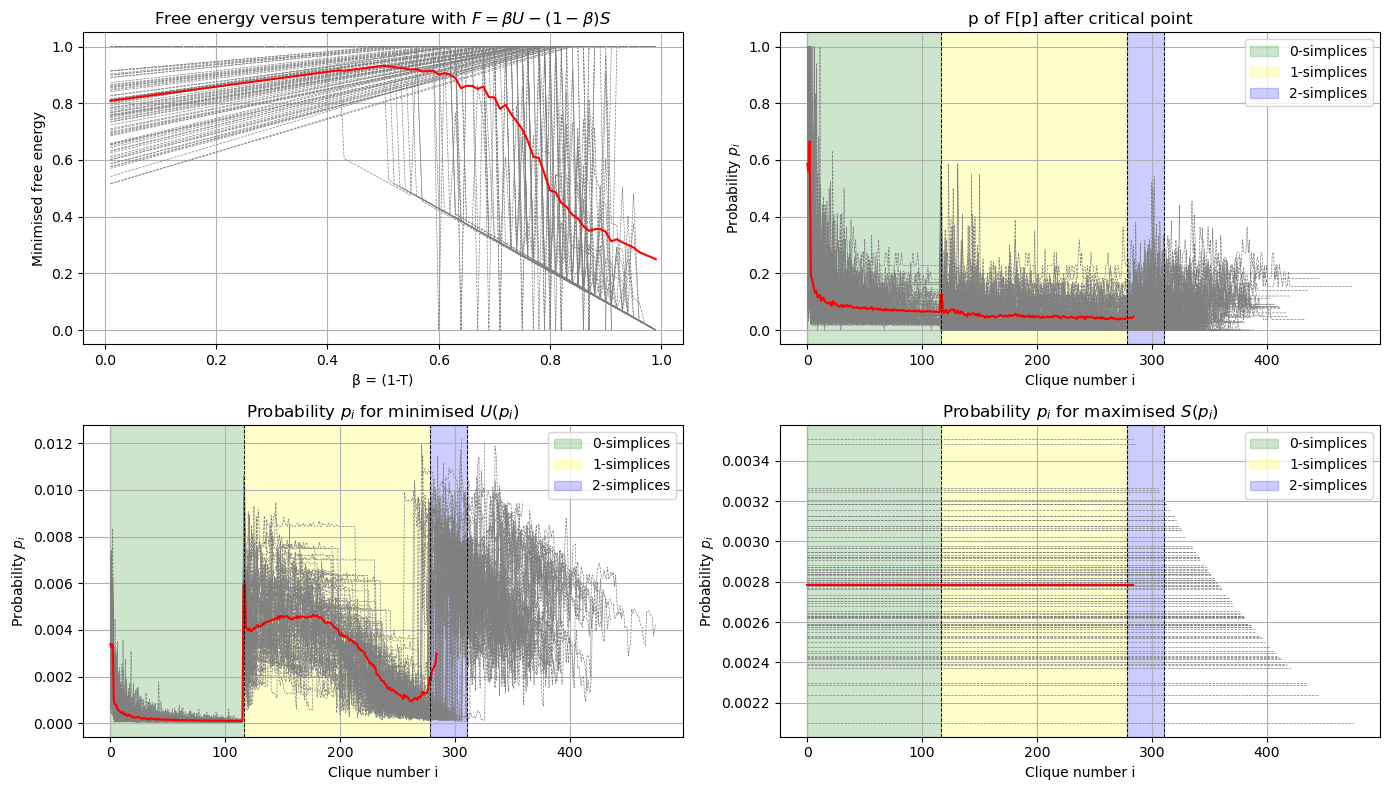

In [163]:
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Plot histograms
# F vs T
for i in range(dataset_size):
    axs[0, 0].plot(temperature_list, f_normalised_iterations[i], color='grey', linestyle='--', linewidth=0.5)
f_list_average = [sum(x) / len(x) for x in zip(*f_normalised_iterations)]
axs[0, 0].plot(temperature_list, f_list_average, color='red')

# Define custom tick positions and labels
custom_ticks = temperature_list
custom_labels = ['Pure S', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 'Pure U']
#axs[0, 0].set_xticks(custom_ticks)
#axs[0, 0].set_xticklabels(custom_labels)

# Rest of plot
axs[0, 0].set_title('Free energy versus temperature with $F= β U - (1-β) S$')
axs[0, 0].set_xlabel('β = (1-T)')
axs[0, 0].set_ylabel('Minimised free energy')
#axs[0, 0].axhline(y=-max_entropy_value, color='b', linestyle='--', label='negative max S (analytical)')
#axs[0, 0].axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
axs[0, 0].grid(True)
#axs[0, 0].legend()

# After phase transition
p_lists = []
for i in range(dataset_size):
    p_list = p_normalised_iterations[i]
    axs[0, 1].plot(p_list[2], color='grey', linestyle='--', linewidth=0.5)
    p_lists.append(p_list[2])
p_list_average = average_list(p_lists)
axs[0, 1].plot(p_list_average, color='red')
axs[0, 1].set_title('p of F[p] after critical point')
axs[0, 1].set_xlabel('Clique number i')
axs[0, 1].set_ylabel('Probability $p_i$')
axs[0, 1].grid(True)

for marker_x in marker_x_values:
    axs[0, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[0, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[0, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[0, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[0, 1].legend(loc='upper right')

# Pure energy
for i in range(dataset_size):
    axs[1, 0].plot(P_Umin_list[i], color='grey', linestyle='--', linewidth=0.5)
P_Umin_average = [sum(x) / len(x) for x in zip(*P_Umin_list)]
axs[1, 0].plot(P_Umin_average, color='red')
axs[1, 0].set_title('Probability $p_i$ for minimised $U(p_i)$')
axs[1, 0].set_xlabel('Clique number i')
axs[1, 0].set_ylabel('Probability $p_i$')
axs[1, 0].grid(True)

for marker_x in marker_x_values:
    axs[1, 0].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[1, 0].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[1, 0].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[1, 0].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[1, 0].legend()

# Pure entropy
for i in range(dataset_size):
    axs[1, 1].plot(P_Smax_list[i], color='grey', linestyle='--', linewidth=0.5)
P_Smax_average = [sum(x) / len(x) for x in zip(*P_Smax_list)]
axs[1, 1].plot(P_Smax_average, color='red')
axs[1, 1].set_title('Probability $p_i$ for maximised $S(p_i)$')
axs[1, 1].set_xlabel('Clique number i')
axs[1, 1].set_ylabel('Probability $p_i$')
axs[1, 1].grid(True)

for marker_x in marker_x_values:
    axs[1, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

axs[1, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
axs[1, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
axs[1, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
axs[1, 1].legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Extend the static plot above to a dynamic gif

In [112]:
frames = []

for frame in range(len(temperature_list)):
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    # Plot title
    if name == 'erdos_renyi':
        plt.suptitle(f'Dynamics for {dataset_size} {name} graphs with density {density}')
    if name == 'scale_free':
        plt.suptitle(f'Dynamics for {dataset_size} {name} graphs with density {density}')
    if name == 'real_data_threshold':
        plt.suptitle(f'Dynamics for {dataset_size} {name} graphs with threshold {threshold}')

    # Plots
    # F vs T
    for i in range(dataset_size):
        axs[0, 0].plot(temperature_list, f_normalised_iterations[i], color='grey', linestyle='--', linewidth=0.5)
    f_list_average = [sum(x) / len(x) for x in zip(*f_normalised_iterations)]
    axs[0, 0].plot(temperature_list, f_list_average, color='red')

    # Define custom tick positions and labels
    custom_ticks = temperature_list
    custom_labels = ['Pure S', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', 'Pure U']
    axs[0, 0].set_xticks(custom_ticks)
    axs[0, 0].set_xticklabels(custom_labels)

    # Rest of plot
    axs[0, 0].set_title('Free energy versus temperature with $F= β U - (1-β) S$')
    axs[0, 0].set_xlabel('β = (1-T)')
    axs[0, 0].set_ylabel('Minimised free energy (normalised)')
    #axs[0, 0].axhline(y=-max_entropy_value, color='b', linestyle='--', label='negative max S (analytical)')
    #axs[0, 0].axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
    axs[0, 0].axvline(x=temperature_list[frame], color='black', linestyle='-', linewidth=1.5)
    axs[0, 0].grid(True)
    #axs[0, 0].legend()

    # After phase transition
    p_lists = []
    for i in range(dataset_size):
        p_list = p_normalised_iterations[i]
        axs[0, 1].plot(p_list[frame], color='grey', linestyle='--', linewidth=0.5)
        p_lists.append(p_list[frame])
    p_list_average = average_list(p_lists)
    axs[0, 1].plot(p_list_average, color='red')
    axs[0, 1].set_title('p of F[p] after critical point')
    axs[0, 1].set_xlabel('Clique number i')
    axs[0, 1].set_ylabel('Probability $p_i$ (normalised)')
    axs[0, 1].set_ylim(0, 1)
    #axs[0, 1].set_xlim(0, 500)
    axs[0, 1].grid(True)

    for marker_x in marker_x_values:
        axs[0, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[0, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[0, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[0, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[0, 1].legend(loc='upper right')

    # Pure energy
    for i in range(dataset_size):
        axs[1, 0].plot(P_Umin_list[i], color='grey', linestyle='--', linewidth=0.5)
    P_Umin_average = [sum(x) / len(x) for x in zip(*P_Umin_list)]
    axs[1, 0].plot(P_Umin_average, color='red')
    axs[1, 0].set_title('Probability $p_i$ for analytical min $U(p_i)$')
    axs[1, 0].set_xlabel('Clique number i')
    axs[1, 0].set_ylabel('Probability $p_i$')
    #axs[1, 0].set_xlim(0, 500)
    axs[1, 0].grid(True)

    for marker_x in marker_x_values:
        axs[1, 0].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[1, 0].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[1, 0].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[1, 0].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[1, 0].legend()

    # Pure entropy
    for i in range(dataset_size):
        axs[1, 1].plot(P_Smax_list[i], color='grey', linestyle='--', linewidth=0.5)
    P_Smax_average = [sum(x) / len(x) for x in zip(*P_Smax_list)]
    axs[1, 1].plot(P_Smax_average, color='red')
    axs[1, 1].set_title('Probability $p_i$ for analytical max $S(p_i)$')
    axs[1, 1].set_xlabel('Clique number i')
    axs[1, 1].set_ylabel('Probability $p_i$')
    #axs[1, 1].set_xlim(0, 500)
    axs[1, 1].grid(True)

    for marker_x in marker_x_values:
        axs[1, 1].axvline(x=marker_x, color='black', linestyle='--', linewidth=0.7)  # Add vertical dashed lines

    axs[1, 1].axvspan(xmin=0, xmax=N_nodes, alpha=0.2, color='green', label='0-simplices')
    axs[1, 1].axvspan(xmin=N_nodes, xmax=(N_nodes + N_edges), alpha=0.2, color='yellow', label='1-simplices')
    axs[1, 1].axvspan(xmin=(N_nodes + N_edges), xmax=(N_nodes + N_edges + N_triangles), alpha=0.2, color='blue', label='2-simplices')
    axs[1, 1].legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()

    # Convert figure to PIL Image
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Append the current frame to the list of frames
    frames.append(img)

    # Close the figure to avoid memory leaks
    plt.close(fig)

# Save frames as GIF
frames[0].save(f'FvsT_{name}.gif', save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0)

C:\Users\cyril\AppData\Local\Temp\ipykernel_52592\1136075762.py:107: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_52592\1136075762.py:107: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_52592\1136075762.py:107: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_52

# Plot the probability statistics for the chosen dataset

In [91]:
name = 'scale_free'
dataset_size = len(dataset)

In [92]:
# Connect to the SQLite database
conn = sqlite3.connect(f'FvsT_{name}.db')

# Create a cursor object to execute SQL queries
c = conn.cursor()

# Execute a query to fetch the data from the table
c.execute('''SELECT * FROM data''')

# Fetch all rows from the result set
rows = c.fetchall()

# Process the retrieved data to obtain the original lists and arrays
original_data = []
for row in rows:
    list1 = eval(row[1])  # Convert the string representation of the list back to a list
    
    # Convert the string representation of list2 (list of arrays) back to a list of arrays
    list2 = eval(row[2])
    list3 = eval(row[3])
    list4 = eval(row[4]) 
    
    # Convert the string representation of array3 and array4 back to NumPy arrays
    #array3 = np.fromstring(row[3], dtype=float, sep=' ')
    #array4 = np.fromstring(row[4], dtype=float, sep=' ')
    
    original_data.append((list1, list2, list3, list4))

# Close the connection
conn.close()

# Connect to desired lists
f_list_iterations = list(zip(*original_data))[0]
p_list_iterations = list(zip(*original_data))[1]
P_Umin_list = list(zip(*original_data))[2]
P_Smax_list = list(zip(*original_data))[3]

In [164]:
p_normalised_iterations = []

for p_list in p_list_iterations:
    p_normalised_list = []

    for p_distribution in p_list:
        min_val = min(p_distribution)
        max_val = max(p_distribution)
        if min_val != max_val:
            p_normalised = [(val-min_val)/(max_val-min_val) for val in p_distribution]
        else:
            p_normalised = [0.5]*len(p_distribution)
        p_normalised_list.append(p_normalised)

    p_normalised_iterations.append(p_normalised_list)

In [165]:
means_iterations = []
stds_iterations = []

for p_list in p_normalised_iterations:
    
    probability_means = []
    probability_stds = []

    for probabilities in p_list:
        # Calculate mean and standard deviation for the flattened list
        mean = statistics.mean(probabilities)
        std_dev = statistics.stdev(probabilities)

        # Stored data in list
        probability_means.append(mean)
        probability_stds.append(std_dev)

    means_iterations.append(probability_means)
    stds_iterations.append(probability_stds)

In [166]:
probabilities_per_temp_list = []

for i in range(len(temperature_list)):
    probabilities_per_temp = [sublist[i] for sublist in p_normalised_iterations]
    probabilities_per_temp = [item for sublist in probabilities_per_temp for item in sublist]
    probabilities_per_temp_list.append(probabilities_per_temp)

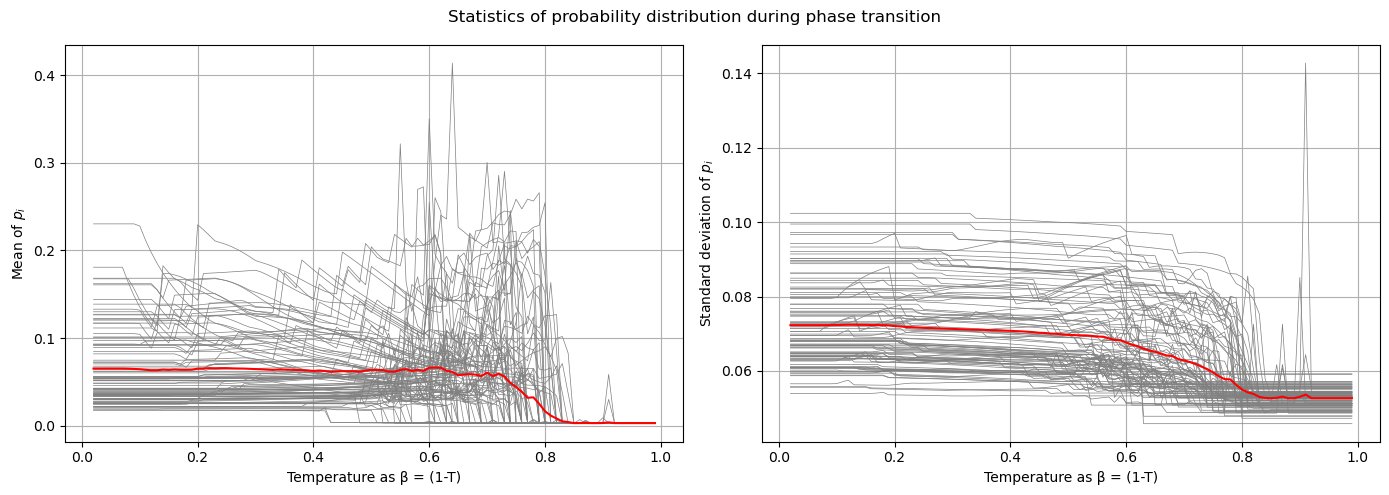

In [167]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Statistics of probability distribution during phase transition")

# Plot means
for probability_means in means_iterations:
    ax1.plot(temperature_list[1:], probability_means[1:], color='grey', linewidth=0.5)
means_average = [sum(x) / len(x) for x in zip(*means_iterations)]
ax1.plot(temperature_list[1:], means_average[1:], color='red')
ax1.set_ylabel("Mean of $p_i$")
ax1.set_xlabel("Temperature as β = (1-T)")
ax1.grid(True)

# Plot standard deviations
for probability_stds in stds_iterations:
    ax2.plot(temperature_list[1:], probability_stds[1:], color='grey', linewidth=0.5)
stds_average = [sum(x) / len(x) for x in zip(*stds_iterations)]
ax2.plot(temperature_list[1:], stds_average[1:], color='red')
ax2.set_ylabel("Standard deviation of $p_i$")
ax2.set_xlabel("Temperature as β = (1-T)")
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [168]:
frames = []

for i in range(len(temperature_list)):
    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [4, 4, 1]})
    fig.suptitle("Statistics of probability distribution during phase transition")

    # Plot standard deviations
    for probability_stds in stds_iterations:
        ax1.plot(temperature_list[1:], probability_stds[1:], color='grey', linewidth=0.5)
    stds_average = [sum(x) / len(x) for x in zip(*stds_iterations)]
    ax1.plot(temperature_list[1:], stds_average[1:], color='red')
    ax1.axvline(x=temperature_list[i], color='black', linestyle='-', linewidth=1.5)
    ax1.set_ylabel("Standard deviation of $p_i$")
    ax1.set_xlabel("Temperature as β = (1-T)")
    ax1.grid(True)

    # Plot means
    for probability_means in means_iterations:
        ax2.plot(temperature_list[1:], probability_means[1:], color='grey', linewidth=0.5)
    means_average = [sum(x) / len(x) for x in zip(*means_iterations)]
    ax2.plot(temperature_list[1:], means_average[1:], color='red')
    ax2.axvline(x=temperature_list[i], color='black', linestyle='-', linewidth=1.5)
    ax2.set_ylabel("Mean value of $p_i$")
    ax2.set_xlabel("Temperature as β = (1-T)")
    ax2.grid(True)

    # Plot histogram
    ax3.hist(probabilities_per_temp_list[i][1:], bins=100, label='Real Matrix', alpha=0.4, color='blue', edgecolor='black', orientation='horizontal')
    ax3.set_ylabel("Probability $p_i$ (normalised)")
    ax3.set_xlabel("Frequency")
    ax3.set_xticks([])
    ax3.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()

    # Convert figure to PIL Image
    fig = plt.gcf()  # Get current figure
    fig.canvas.draw()  # Draw the figure
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Append the current frame to the list of frames
    frames.append(img)

    # Clear the figure to avoid memory leaks
    plt.clf()

# Save frames as GIF
frames[0].save(f'Statistics_FvsT_{name}.gif', save_all=True, append_images=frames[1:], optimize=False, duration=100, loop=0)

C:\Users\cyril\AppData\Local\Temp\ipykernel_22872\4231431900.py:41: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
C:\Users\cyril\AppData\Local\Temp\ipykernel_22872\4231431900.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [4, 4, 1]})


<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>

<Figure size 1400x400 with 0 Axes>